In [1]:
%load_ext autoreload
%autoreload 2

## For refitting.py development

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re
import scipy.optimize as opt
from tqdm import tqdm
import sympy as sp
from sympy.parsing.sympy_parser import parse_expr
from sympy import lambdify

In [2]:
filename = 'pareto_low_adv_cleaned.csv'  
t_eq=pd.read_csv('/data/zj448/SR/Ultimate_paper/pareto_archive/'+filename)

df_full = pd.read_csv('SMBH_Data_03_06_24.csv',header=1)

In [3]:
low_scatter_para=['ETG','T-type','Bar', 'Disk', 'Ring', 'Core', 'Multiple', 'Compactness', 'AGN',
       'Pseudobulge', 'BCG', 'cD','M*_sph', 'M*_gal', 'log_B/T',
       'log_sigma0', 'log_R_e_sph_maj','log_R_e_sph_eq_kpc', 'log_n_sph_maj', 'log_n_sph_eq', 'log(I_e,sph,maj/M_Sun/pc^2)',
       'log(I_e,sph,eq/M_Sun/pc^2)', 'Concentration_Index',
       'avg_Rho_1kpc_Exact_All', 'r1_density_approx', 'log10(R10_kpc)',
       'logRho_R10_approx', 'log_rho10_Exact', 'log10(R90_kpc)',
       'logRho_R90_approx', 'log_rho_90_Exact_all', 'Rho_re_spatial',
       'SR_pc_All', 'Rho_SR_pc_All', 'CR_def1_approx_new',
       'Rho_cr_def1_approx_new', 'CR_def2_approx_new',
       'Rho_CR_def2_approx_new', 'Sr(pc)_2_using_Falserm_drho',
       'Log_Approx_Avg_density_10pc', 'log_Rho_e_Exact_new',
       'logRho_e_approx_New', 'logRho_soi_approx_new',
       'log_Rho_soi_exact_new', 'Avg_Rho_Re_Exact_all',
       'Avg_Rho_soi_exact_all', 'Avg_Rho_re_Exact_all', 'Rho_re_Exact_all',
       'Rho_r_soi_2BH_approx', 'Log_Avg_Rho_10kpc_approx',
       'Log_Avg_Rho_10kpc_exact_final', 'Log_Avg_Rho_100pc_approx',
       'Log_Avg_Rho_5kpc_approx', 'Log_Avg_rho_5kpc_exact_all', 'ube', 'bve',
       'dc', 'bvtc', 'bri25', 'mabs', 'blum', 'logblum', 'logSigma0sph',
       'LogSigma0', 'R10', 'logR10', 'logR10phi', 'Rh', 'logRh', 'logRhphi',
       'logHalo','B-V','V-[3.6]','GJC23W1-W2','GJC23W2-W3','GJC23log(M*,gal/M_sun)',
       'GJC23log(SFR)','GJC23log(sSFR)','log<Sigma>_e','log<Sigma>_h','M_BH']

easy_obs_para=['LogSigma0','Concentration_Index','logSigma0sph','log_sigma0','dc','logRhphi','M*_sph','ube','bri25','bve','bvtc','logR10phi','M*_gal','log_B/T',
 'logRh','log_n_sph_eq','blum','log_R_e_sph_maj','logblum','log_n_sph_maj','logR10','Pseudobulge','AGN','Multiple','Ring','BCG','Disk','cD',
 'Bar','Core','Compactness','ETG','T-type','M_BH','log10(R10_kpc)','log10(R90_kpc)','B-V','V-[3.6]','GJC23W1-W2','GJC23W2-W3','GJC23log(M*,gal/M_sun)','M_BH']

low_scatter_para.append('M_BH_std_sym')
easy_obs_para.append('M_BH_std_sym')

In [4]:
df=df_full[low_scatter_para]
df=df.dropna()
len(df)

93

In [5]:
t_eq['LLL']=0.
t_eq['intrinsic_scatter']=0.
t_eq['refit_equation']=''
t_eq['refit_wrmse']=0.

number_matching_pattern = r"(?<![a-zA-Z0-9_.])[+-]?(\d+\.\d+|\.\d+|\d+\.|\d+)(?:[eE][-+]?\d+)?"


def predict(equation):
    func=str2equ(equation)
    labels = re.findall(r'x(\d+)', equation)
    labels = list(dict.fromkeys(labels))
    labels = [int(label) for label in labels]

    x=[]
    for i in range(len(labels)):
        x.append(df[low_scatter_para[labels[i]]])

    return func(*x)

def str2equ(equation):
    return lambdify(list(dict.fromkeys(re.findall(r'\bx\d+',equation))),equation)

def wrmse(y,y_pred,w):
    return np.average((y-y_pred)**2,weights=w)

mu_obs = df['M_BH']
sigma_y_obs2 = df['M_BH_std_sym']*df['M_BH_std_sym']
w=1/sigma_y_obs2

for row in tqdm(t_eq.iterrows(),total=len(t_eq)):

    equation = row[1]['fitting_format']

    variable_list=[]
    for i in range(row[1]['num_fitting_variables']):
        variable_list.append('p['+str(i)+']')
    
    constants = row[1]['initial_constant_guess']
    constants = eval(constants)
    
    print(equation)

    labels = re.findall(r'x(\d+)', equation)
    labels = list(dict.fromkeys(labels))
    labels = [int(label) for label in labels]

    x=[]
    for i in range(len(labels)):
        x.append(df[low_scatter_para[labels[i]]])

    mu_obs = df['M_BH']

    sigma_y_obs2 = df['M_BH_std_sym']*df['M_BH_std_sym']

    ##############################
    def loglikelihood(p):

        equation_=equation

        # swap constants in for p[i]
        for i in range(len(variable_list)):
            equation_ = equation_.replace(variable_list[i],str(p[i]))

        #print(equation_)

        func = str2equ(equation_)

        mu_pred = func(*x)
        sigma_y =  np.sqrt(sigma_y_obs2 + p[-1]*p[-1])
        #sigma_y =  np.sqrt(sigma_y_obs2)
        norm_residuals = (mu_obs - mu_pred) / sigma_y

        log_l = -0.5*len(df)*np.log(2*np.pi) -np.log(sigma_y).sum() - 0.5*(norm_residuals*norm_residuals).sum()

        #print(log_l)
        return -log_l
    ###############################


    for i in range(len(constants)):
        constants[i]=np.float64(constants[i])
    current_parameter_vector=np.array(constants)
    current_parameter_vector=np.append(current_parameter_vector,0.3) # last p is intrinsic scatter


    result = opt.minimize(loglikelihood, current_parameter_vector, method='Nelder-Mead', tol=1e-5, options={'maxiter':5e4, 'maxfev':5e4, 'adaptive':True})

    new_equation = equation
    for i in range(len(variable_list)):
        new_equation = new_equation.replace(variable_list[i],str(result.x[i]))
    t_eq.loc[row[0],'refit_equation']=new_equation

    refit_wrmse = wrmse(mu_obs,predict(t_eq.iloc[row[0]]['refit_equation']),w)
    if np.isnan(refit_wrmse):
        t_eq.loc[row[0],'refit_wrmse']=np.nan
        t_eq.loc[row[0],'LLL']=np.nan
        t_eq.loc[row[0],'intrinsic_scatter']=np.nan
    
    else:
        t_eq.loc[row[0],'refit_wrmse']=refit_wrmse
        t_eq.loc[row[0],'LLL']=-loglikelihood(current_parameter_vector)
        t_eq.loc[row[0],'intrinsic_scatter']=result.x[-1]

  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 2/1042 [00:00<01:21, 12.70it/s]

x66
x73 + p[0]
-p[1]*x42 + x53 + x69 + p[0]
-p[2]*x42 + x53 + x69 + p[1] - p[4]/(p[3]*x51 + p[0])


  0%|          | 4/1042 [00:02<10:12,  1.69it/s]

p[4]*exp(exp(p[0]/(p[6] - p[1]*x52)**p[5])) + p[2] + log10(p[3]*x23)/x43


  0%|          | 4/1042 [00:05<24:14,  1.40s/it]


KeyboardInterrupt: 

In [8]:
t_eq

,complexity,loss,score,equation,sympy_format,lambda_format,number_constants,variables,number_variables,unique_number_variables,...,aic,evolutions,iterations,fitting_format,num_fitting_variables,initial_constant_guess,LLL,intrinsic_scatter,refit_equation,refit_wrmse
0,1,4.885951,0.000000,x69,x69,PySRFunction(X=>x69),0,{'x69'},1,1,...,908.786973,0,0,x69,0,[],-2644.193704,2.495183,x69,4.885951
1,3,0.157051,1.718773,(x69 + x49),x49 + x69,PySRFunction(X=>x49 + x69),0,"{'x69', 'x49'}",2,2,...,29.211556,0,0,x49 + x69,0,[],-132.237834,0.575609,x49 + x69,0.157051
2,7,0.127908,0.058997,(((x12 + x49) - x73) - x17),x12 - x17 + x49 - x73,PySRFunction(X=>x12 - x17 + x49 - x73),0,"{'x12', 'x49', 'x73', 'x17'}",4,4,...,23.790881,0,0,x12 - x17 + x49 - x73,0,[],-113.504567,0.536001,x12 - x17 + x49 - x73,0.127908
3,11,0.117943,0.020278,(((x69 + x49) - (log10(2.233044520137043) / ex...,x49 + x69 - x73 - 0.8033659100247211*exp(-x56)...,PySRFunction(X=>x49 + x69 - x73 - 0.8033659100...,1,"{'x69', 'x49', 'x73', 'x56'}",4,4,...,23.937366,0,0,x49 + x69 - x73 - log10(p[0])*exp(-x56),1,['2.233044520137043'],NaN,NaN,x49 + x69 - x73 - log10(-0.19310753116117474)*...,NaN
4,15,0.105290,0.028371,((((x13 + x53) + -0.4385317648318854) + (((0.5...,x13 + x53 - x65 + (0.5787281095217448**x42)**1...,PySRFunction(X=>x13 + x53 - x65 + (0.578728109...,4,"{'x42', 'x65', 'x13', 'x53'}",4,4,...,27.583895,0,0,x13 + x53 - x65 + (p[0]**x42)**p[1] - p[2],3,"['0.5787281095217448', '1.1072374946867565', '...",-75.852376,0.438619,x13 + x53 - x65 + (0.566708231503907**x42)**0....,0.108121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,13,0.021503,0.158455,(((x15 / 0.2781055358753451) + x19) - (log10(e...,3.595757261186734*x15 + x19 - log(exp(x42)/x21...,PySRFunction(X=>3.595757261186734*x15 + x19 - ...,2,"{'x42', 'x19', 'x15', 'x21'}",4,4,...,7.999501,0,1872,p[0]*x15 + x19 - log10(exp(x42)/x21) + p[1],2,"['3.595757261186734', '0.38990846927012623']",-21.956161,0.239813,3.422088700384049*x15 + x19 - log10(exp(x42)/x...,0.023058
60,19,0.019478,0.001638,(((x15 / 0.2781055358753451) + x19) - (log10((...,3.595757261186734*x15 + x19 - log((x2 + x8 + e...,PySRFunction(X=>3.595757261186734*x15 + x19 - ...,3,"{'x42', 'x19', 'x2', 'x15', 'x21', 'x8'}",6,6,...,9.622973,0,1872,p[0]*x15 + x19 - log10((x2 + x8 + exp(x42) - p...,3,"['3.595757261186734', '0.5889051845565962', '0...",-19.347105,0.223603,3.321319736068659*x15 + x19 - log10((x2 + x8 +...,0.020402
61,21,0.019439,0.001002,(((x15 / 0.2781055358753451) + x19) - (log10((...,3.595757261186734*x15 + x19 - log((x2 + x73 + ...,PySRFunction(X=>3.595757261186734*x15 + x19 - ...,3,"{'x42', 'x19', 'x2', 'x15', 'x21', 'x8', 'x73'}",7,7,...,9.615720,0,1872,p[0]*x15 + x19 - log10((x2 + x73 + x8 + exp(x4...,3,"['3.595757261186734', '0.5889051845565962', '0...",-19.124593,0.222083,3.310923746501202*x15 + x19 - log10((x2 + x73 ...,0.020351
62,4,0.115187,0.184676,(log10(x15) * 23.41780258431442),23.41780258431442*log(x15)/log(10),PySRFunction(X=>23.41780258431442*log(x15)/log...,1,{'x15'},1,1,...,23.424861,0,1908,p[0]*log10(x15),1,['23.41780258431442'],-96.489604,0.480893,23.07503029440484*log10(x15),0.130350


## Visualize the results of refitting.py

In [8]:
filename = 'pareto_low_adv_cleaned.csv'
t_eq = pd.read_csv('/data/zj448/SR/Ultimate_paper/pareto_archive/'+filename[:-12]+'_refit.csv')

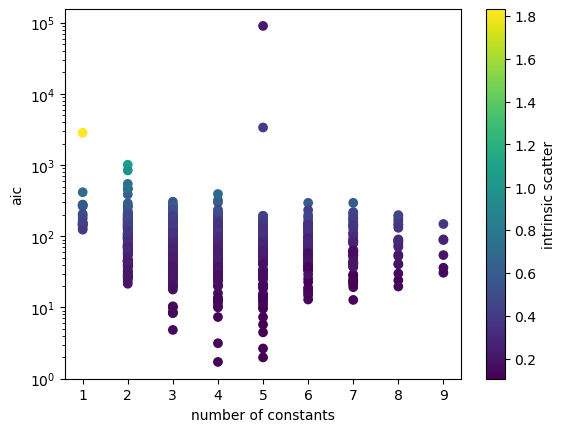

In [10]:
aic = -2*t_eq['LLL']+2*(t_eq['number_constants']+1)
t_eq['AIC']=aic
plt.scatter(t_eq['number_constants']+1,aic,c=t_eq['intrinsic_scatter'])
plt.xlabel('number of constants')
plt.ylabel('aic')
#plt.ylim(0,1000)
plt.yscale('log')
plt.colorbar().set_label('intrinsic scatter')

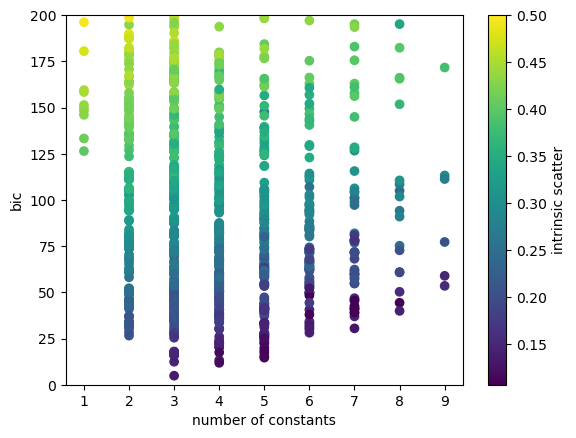

In [14]:
bic = -2*t_eq['LLL']+np.log(len(df))*(t_eq['number_constants']+1)
t_eq['BIC']=bic
plt.scatter(t_eq['number_constants']+1,bic,c=np.clip(t_eq['intrinsic_scatter'],0,0.5))
plt.xlabel('number of constants')
plt.ylabel('bic')
plt.ylim(0,200)
#plt.yscale('log')
plt.colorbar().set_label('intrinsic scatter')

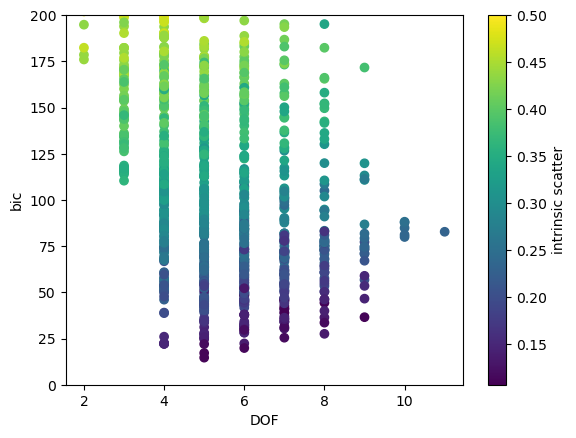

In [16]:
dof = np.maximum(t_eq['number_constants'],t_eq['unique_number_variables'])+1
bic = np.array(-2*t_eq['LLL']+np.log(len(df))*dof)
t_eq['BIC']=bic
t_eq['DOF']=dof
plt.scatter(dof,bic,c=np.clip(t_eq['intrinsic_scatter'],0,0.5))
plt.xlabel('DOF')
plt.ylabel('bic')
plt.ylim(0,200)
#plt.yscale('log')
plt.colorbar().set_label('intrinsic scatter')

In [17]:
#aic.argmin()

In [18]:
bic.argsort(),bic[bic.argsort()]

(array([668, 667, 669, ..., 976,  62, 290]),
 array([14.65025918, 17.13927014, 19.85077442, ...,         nan,
                nan,         nan]))

In [19]:
def view_equation(index,var_list=low_scatter_para):
    print('equation:',parse_expr(t_eq.iloc[index]['refit_equation']))
    display(parse_expr(t_eq.iloc[index]['refit_equation']))
    unique_variables = list(dict.fromkeys(re.findall(r'\bx\d+',t_eq.iloc[index]['refit_equation'])))
    #print(unique_variables)
    for i in range(len(unique_variables)):
        print(unique_variables[i],':',var_list[int(unique_variables[i][1:])])
    
    print('intrinsic scatter:',t_eq.iloc[index]['intrinsic_scatter'])
    print('wrmse:',t_eq.iloc[index]['refit_wrmse'])
    print('AIC:',t_eq.iloc[index]['AIC'])
    print('BIC:',t_eq.iloc[index]['BIC'])
    print('DOF:',t_eq.iloc[index]['DOF'])
    return None

In [22]:
view_equation(668)

equation: x15*(-x42/(x39 - 0.31672307501702807*x9**3.1865675724962745) + 3.1865675724962745) + 2.8150715678888734


x15*(-x42/(x39 - 0.31672307501702807*x9**3.1865675724962745) + 3.1865675724962745) + 2.8150715678888734

x15 : log_sigma0
x42 : logRho_soi_approx_new
x39 : Log_Approx_Avg_density_10pc
x9 : Pseudobulge
intrinsic scatter: 0.1103512466094481
wrmse: 0.0110927234763259
AIC: 1.987261711459567
BIC: 14.650259177225848
DOF: 5


In [23]:
view_equation(667)

equation: x15*(-x42/(x39 - 1.6322270478662237*x9*exp(log10(0.02292577291225005))) + 3.186565360215331) + 2.815076740955496


x15*(-x42/(x39 - 1.6322270478662237*x9*exp(log10(0.02292577291225005))) + 3.186565360215331) + 2.815076740955496

x15 : log_sigma0
x42 : logRho_soi_approx_new
x39 : Log_Approx_Avg_density_10pc
x9 : Pseudobulge
intrinsic scatter: 0.1103510075903271
wrmse: 0.0110927353915686
AIC: 4.476272671352103
BIC: 17.139270137118384
DOF: 5


In [35]:
view_equation(bic.argsort()[10])

equation: x15*(-x42/(x39 - 0.24128548638905772*exp(x29)) + 3.1992793135763167) + 2.777216515912795


x15*(-x42/(x39 - 0.24128548638905772*exp(x29)) + 3.1992793135763167) + 2.777216515912795

x15 : log_sigma0
x42 : logRho_soi_approx_new
x39 : Log_Approx_Avg_density_10pc
x29 : logRho_R90_approx
intrinsic scatter: 0.1343816031830453
wrmse: 0.0127810895770624
AIC: 10.028442219730522
BIC: 24.691439685496803
DOF: 5


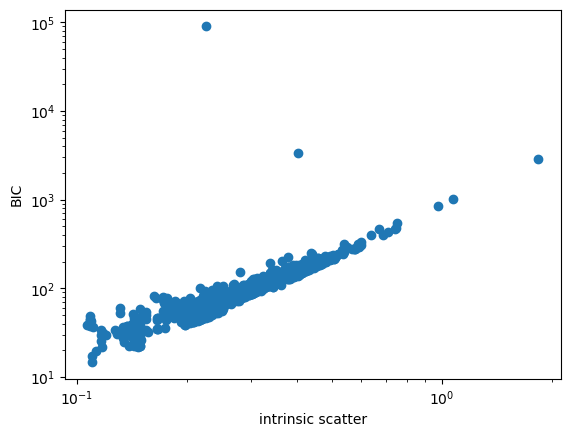

In [24]:
plt.scatter(t_eq['intrinsic_scatter'],t_eq['BIC'])
plt.xlabel('intrinsic scatter')
plt.ylabel('BIC')
plt.yscale('log')
plt.xscale('log')

(-2000.0, 500.0)

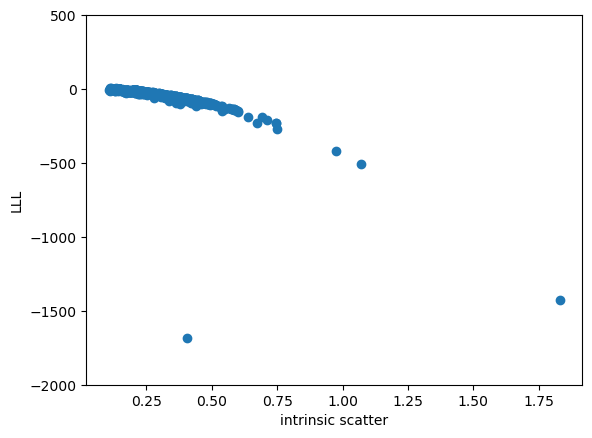

In [32]:
plt.scatter(t_eq['intrinsic_scatter'],t_eq['LLL'])
plt.xlabel('intrinsic scatter')
plt.ylabel('LLL')
plt.ylim(-2000,500)
#plt.yscale('log')
#plt.xscale('log')